In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [6]:
df = pd.read_csv(r"C:\Users\iPC\College ML Project\AI trolley problem\Shared_data_allResponses.csv")
df = df.drop(columns=['_id', 'UserID', 'Session_id', 'Scenario_order', 'Template'])

label_encoders = {}
for col in ['Scenario', 'lang', 'country_code']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
df['Outcome'] = LabelEncoder().fit_transform(df['Outcome'].astype(str))

In [7]:
reasons = [
    "I think flipping the switch saves more lives.",
    "It’s not my place to intervene.",
    "I don't want to directly cause a death.",
    "Saving five people makes more sense.",
    "I’m uncomfortable making that choice.",
]
df['user_reason'] = [reasons[i % len(reasons)] for i in range(len(df))]

In [8]:
vectorizer = TfidfVectorizer(max_features=100)
X_text = vectorizer.fit_transform(df['user_reason'])

X_structured = df.drop(columns=['Outcome', 'user_reason'])
for col in X_structured.columns:
    if X_structured[col].dtype == 'O':
        le = LabelEncoder()
        X_structured[col] = le.fit_transform(X_structured[col].astype(str))

X_structured = X_structured.astype(float)
X_structured_sparse = csr_matrix(X_structured)

X = hstack([X_text, X_structured_sparse])
y = df['Outcome']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.17      0.26     13927
           1       0.72      0.93      0.81     32168

    accuracy                           0.70     46095
   macro avg       0.61      0.55      0.53     46095
weighted avg       0.66      0.70      0.64     46095



 98%|===================| 195/200 [00:15<00:00]        

<Figure size 640x480 with 0 Axes>

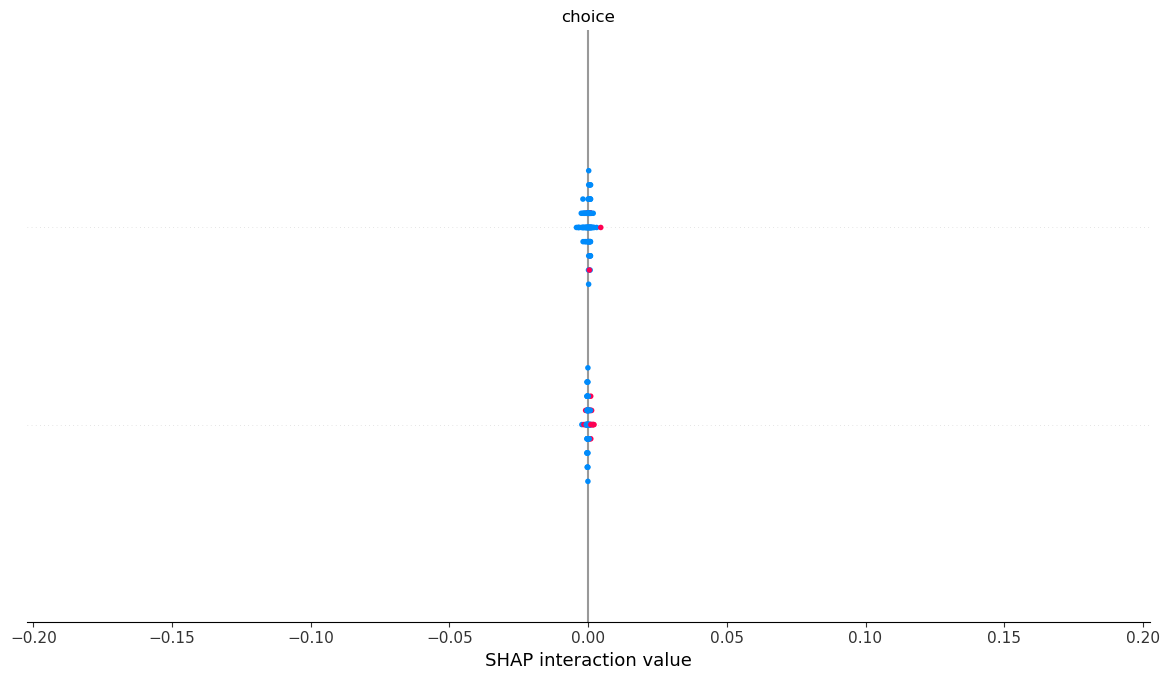

In [16]:
X_train_sample = X_train[:100].toarray()
X_test_sample = X_test[:100].toarray()

explainer = shap.Explainer(model, X_train_sample)
shap_values = explainer(X_test_sample)

feature_names = list(vectorizer.get_feature_names_out()) + list(X_structured.columns)
shap.summary_plot(shap_values, features=X_test_sample, feature_names=feature_names)

In [18]:
df_test = df.iloc[y_test.index] if hasattr(y_test, 'index') else df.sample(len(y_test), random_state=42)
df_test = df_test.reset_index(drop=True)

df_test['y_true'] = y_test
df_test['y_pred'] = y_pred
df_test['correct'] = (df_test['y_true'] == df_test['y_pred']).astype(int)

In [22]:
def group_accuracy(df, group_col):
    acc = df.groupby(group_col)['correct'].mean().sort_values(ascending=False)
    print(f"\nAccuracy by {group_col}:")
    print(acc)
    acc.plot(kind='bar', figsize=(10, 4), title=f"Model Accuracy by {group_col}")
    plt.ylabel("Accuracy")
    plt.xlabel(group_col)
    plt.show()


Accuracy by country_code:
country_code
144    1.0
164    1.0
166    1.0
28     1.0
54     0.5
      ... 
56     0.0
55     0.0
1      0.0
52     0.0
90     0.0
Name: correct, Length: 154, dtype: float64


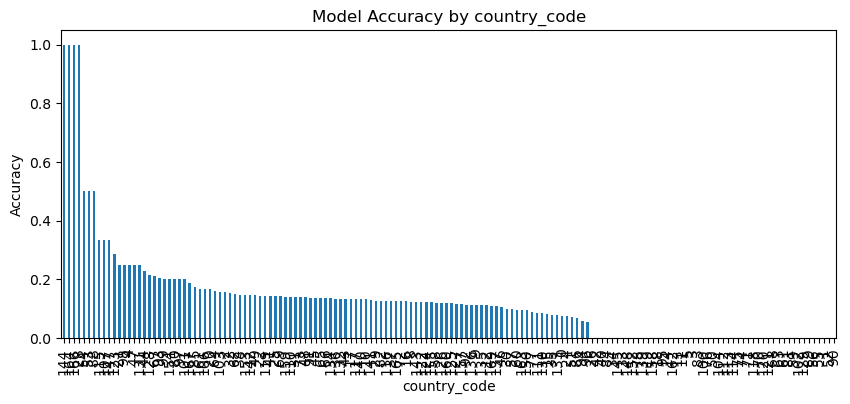


Accuracy by lang:
lang
0    0.176471
7    0.139919
2    0.138040
4    0.131579
3    0.128727
1    0.125217
6    0.118182
8    0.114488
9    0.103292
5    0.077465
Name: correct, dtype: float64


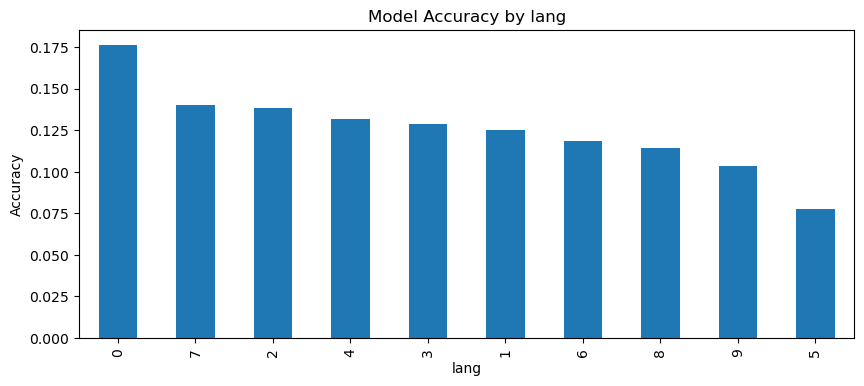


Accuracy by Scenario:
Scenario
2    0.141962
1    0.140597
0    0.116777
Name: correct, dtype: float64


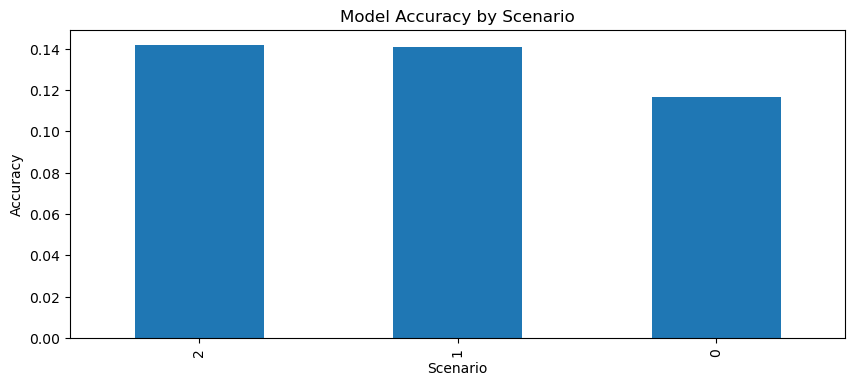

In [24]:
group_accuracy(df_test, 'country_code')
group_accuracy(df_test, 'lang')
group_accuracy(df_test, 'Scenario')

In [26]:
joblib.dump(model, "trolley_model.pkl")

['trolley_model.pkl']